## Preprocessing

In [250]:
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [251]:
!pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [252]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
plt.rcParams['figure.facecolor'] = 'white'
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import seaborn as sns
from sklearn.linear_model import LassoCV
import xgboost as xgb
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.inspection import permutation_importance

In [253]:
! pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [254]:
raw_data = pd.read_table("data_mrna_seq_v2_rsem.txt", sep="\t")
raw_data.head()

,Hugo_Symbol,Entrez_Gene_Id,TCGA-05-4244-01,TCGA-05-4249-01,TCGA-05-4250-01,TCGA-05-4382-01,TCGA-05-4384-01,TCGA-05-4389-01,TCGA-05-4390-01,TCGA-05-4395-01,...,TCGA-NJ-A4YG-01,TCGA-NJ-A4YI-01,TCGA-NJ-A4YP-01,TCGA-NJ-A4YQ-01,TCGA-NJ-A55A-01,TCGA-NJ-A55O-01,TCGA-NJ-A55R-01,TCGA-NJ-A7XG-01,TCGA-O1-A52J-01,TCGA-S2-AA1A-01
0,NaN,100130426,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,NaN,100133144,10.0113,7.1957,7.2453,11.3311,3.2254,4.0000,7.1084,3.4360,...,11.7148,3.6657,2.3298,16.3214,20.3514,15.5193,8.4195,42.9857,14.0861,20.5338
2,UBE2Q2P2,100134869,11.2820,12.4436,6.0184,7.5740,3.4942,13.7852,7.5810,12.1335,...,11.9573,9.7617,8.3410,7.5330,17.2393,22.9872,10.3226,81.1128,24.1914,8.9500
3,HMGB1P1,10357,49.5994,90.5117,49.5366,82.8303,72.5351,66.3658,109.1810,57.0596,...,163.5740,130.7490,101.7400,82.4231,100.4200,100.1870,74.7210,85.3715,61.1388,76.9265
4,NaN,10431,848.9400,924.0160,1140.6800,807.1730,562.0040,1342.6200,1148.3300,955.9140,...,919.1690,403.4910,918.9530,995.6060,536.7600,873.9790,766.7450,677.7330,1137.3200,565.4330


## Preprocessing 

In [255]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data[raw_data.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data.iloc[:,:2].copy()
gene_symbol_id.tail()

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


,Hugo_Symbol,Entrez_Gene_Id
20526,ZYG11A,440590
20527,ZYG11B,79699
20528,ZYX,7791
20529,ZZEF1,23140
20530,ZZZ3,26009


In [256]:
data_clean = raw_data.set_index("Entrez_Gene_Id").drop("Hugo_Symbol",axis=1).transpose()
print(f"There are {len(data_clean)} samples in total & there are {len(data_clean.columns)} genes in total.")
data_clean.head()

There are 510 samples in total & there are 20531 genes in total.


Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-05-4244-01,0.0,10.0113,11.2820,49.5994,848.940,0.0,345.2310,1.0472,0.0000,0.0,...,221.164,517.672,39.7940,292.521,959.246,0.6981,1088.050,2837.94,871.28,575.268
TCGA-05-4249-01,0.0,7.1957,12.4436,90.5117,924.016,0.0,145.2020,1.6098,0.0000,0.0,...,198.589,287.507,62.1376,493.560,1179.330,20.2833,787.506,2351.25,1138.12,690.275
TCGA-05-4250-01,0.0,7.2453,6.0184,49.5366,1140.680,0.0,51.7284,0.0000,0.0000,0.0,...,520.899,1046.840,60.0182,365.415,843.903,26.5274,475.172,5437.45,1170.52,532.869
TCGA-05-4382-01,0.0,11.3311,7.5740,82.8303,807.173,0.0,240.0220,0.4786,0.2393,0.0,...,429.630,753.090,40.4424,346.752,946.687,64.8514,908.159,6770.15,1169.24,663.830
TCGA-05-4384-01,0.0,3.2254,3.4942,72.5351,562.004,0.0,274.2820,0.6109,0.0000,0.0,...,258.302,153.940,80.0244,563.225,1320.710,7.9414,778.864,3341.48,1737.32,723.274


In [257]:
# NA Values 
print(f"If NA values exist: {data_clean.isnull().values.any()}")

# Columns with all the same value
unique_counts = data_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()
print(f"There are {len(same_value_cols)} columns with the same value.")
print(f"{same_value_cols[0:10]}...")

If NA values exist: False
There are 340 columns with the same value.
[317712, 404770, 728045, 100131137, 143501, 9085, 253175, 286828, 653282, 267012]...


In [258]:
df_clean = data_clean.drop(same_value_cols, axis = 1)
df_clean.head()

Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,340602,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-05-4244-01,0.0,10.0113,11.2820,49.5994,848.940,0.0,345.2310,1.0472,0.0000,0.0000,...,221.164,517.672,39.7940,292.521,959.246,0.6981,1088.050,2837.94,871.28,575.268
TCGA-05-4249-01,0.0,7.1957,12.4436,90.5117,924.016,0.0,145.2020,1.6098,0.0000,0.0000,...,198.589,287.507,62.1376,493.560,1179.330,20.2833,787.506,2351.25,1138.12,690.275
TCGA-05-4250-01,0.0,7.2453,6.0184,49.5366,1140.680,0.0,51.7284,0.0000,0.0000,0.0000,...,520.899,1046.840,60.0182,365.415,843.903,26.5274,475.172,5437.45,1170.52,532.869
TCGA-05-4382-01,0.0,11.3311,7.5740,82.8303,807.173,0.0,240.0220,0.4786,0.2393,7.6577,...,429.630,753.090,40.4424,346.752,946.687,64.8514,908.159,6770.15,1169.24,663.830
TCGA-05-4384-01,0.0,3.2254,3.4942,72.5351,562.004,0.0,274.2820,0.6109,0.0000,0.0000,...,258.302,153.940,80.0244,563.225,1320.710,7.9414,778.864,3341.48,1737.32,723.274


In [259]:
adata= sc.AnnData(data_clean)
print(adata.var)

Empty DataFrame
Columns: []
Index: [100130426, 100133144, 100134869, 10357, 10431, 136542, 155060, 26823, 280660, 317712, 340602, 388795, 390284, 391343, 391714, 404770, 441362, 442388, 553137, 57714, 645851, 652919, 653553, 728045, 728603, 728788, 729884, 8225, 90288, 1, 29974, 54715, 87769, 2, 144568, 53947, 51146, 404744, 8086, 65985, 729522, 13, 344752, 126767, 343066, 51166, 79719, 22848, 14, 15, 16, 57505, 80755, 132949, 60496, 10157, 26574, 9625, 18, 10349, 19, 79963, 26154, 154664, 650655, 20, 21, 24, 23461, 23460, 10347, 10351, 10350, 23456, 8647, 5243, 5244, 340273, 10058, 22, 11194, 23457, 89845, 85320, 94160, 150000, 4363, 1244, 8714, 10257, 10057, 368, 653190, 730013, 6833, 10060, 215, 225, 5825, 5826, ...]

[20531 rows x 0 columns]


## Data Visualization 

normalizing counts per cell
    finished (0:00:00)


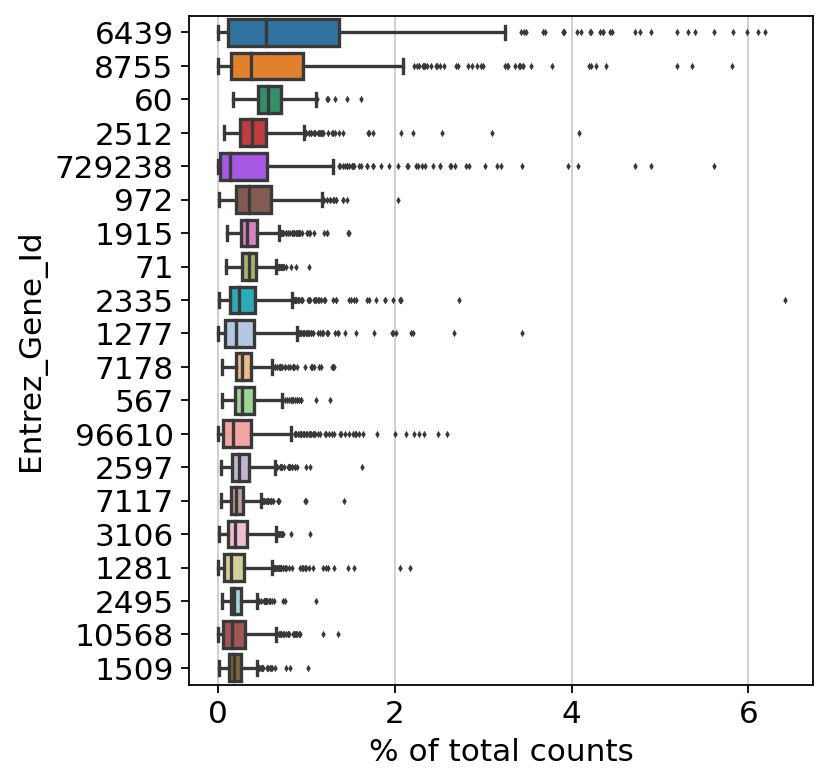

In [260]:
# Output top 20 genes with the high expression levels
sc.pl.highest_expr_genes(adata, n_top=20)

In [261]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata, min_dist=0.3)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


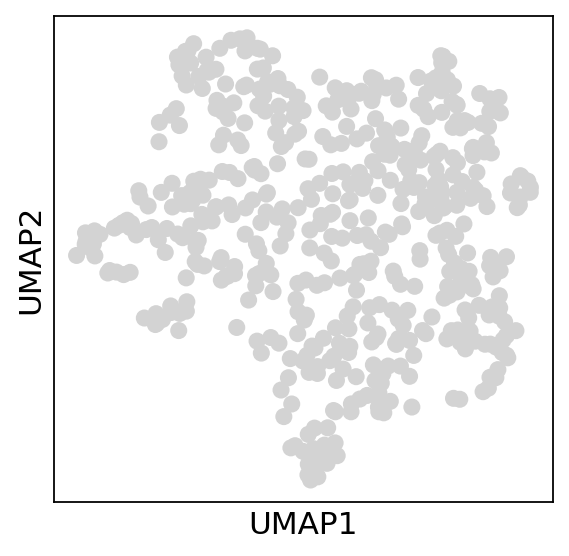

In [262]:
sc.pl.umap(adata)

In [263]:
# Dimensionality reduction using t-SNE
sc.tl.tsne(adata, n_pcs=20)

computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:21)


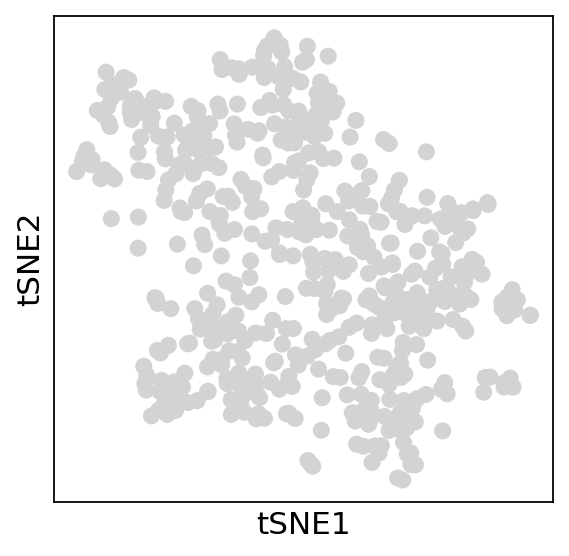

In [264]:
sc.pl.tsne(adata)

## Clustering

In [265]:
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [266]:
sc.tl.leiden(adata, resolution=0.3, key_added="leiden_0.3")
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_0.5")
sc.tl.leiden(adata, resolution=0.7, key_added="leiden_0.7")

running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.7', the cluster labels (adata.obs, categorical) (0:00:00)


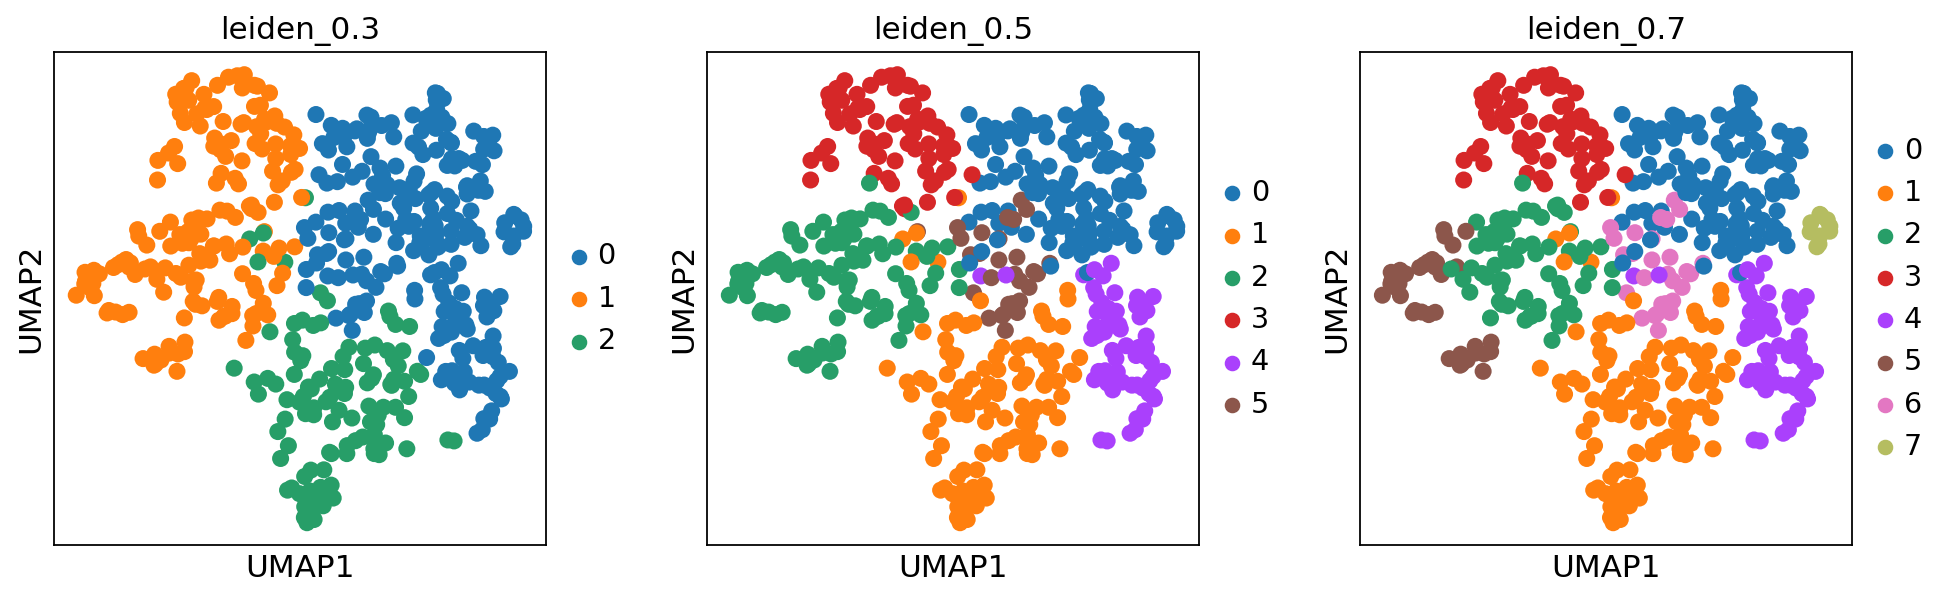

In [267]:
sc.pl.umap(adata, color=['leiden_0.3', 'leiden_0.5', 'leiden_0.7'])

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_0.5']`


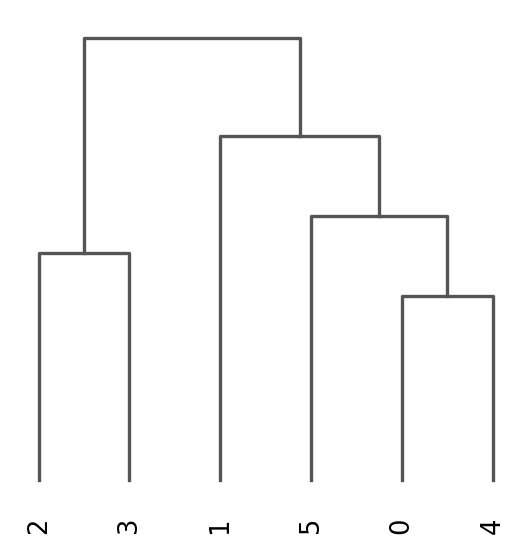

<Axes: >

In [268]:
sc.tl.dendrogram(adata, groupby="leiden_0.5")
sc.pl.dendrogram(adata, groupby="leiden_0.5")

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


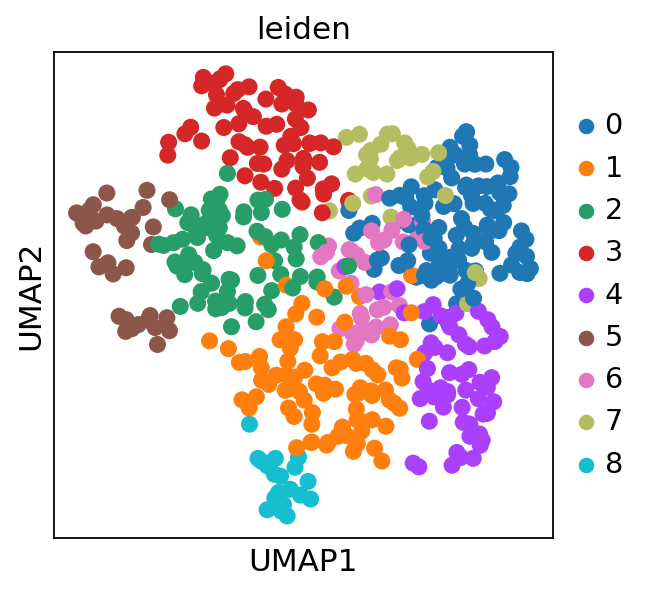

In [269]:
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [270]:
pd.DataFrame(adata.obs['leiden'])

,leiden
TCGA-05-4244-01,2
TCGA-05-4249-01,0
TCGA-05-4250-01,0
TCGA-05-4382-01,1
TCGA-05-4384-01,2
...,...
TCGA-NJ-A55O-01,3
TCGA-NJ-A55R-01,2
TCGA-NJ-A7XG-01,3
TCGA-O1-A52J-01,5


In [271]:
leiden_cluster = pd.DataFrame(adata.obs['leiden']).reset_index(level=0)
leiden_cluster['index'] = leiden_cluster['index'].str[:-3]

## K-Means Clustering

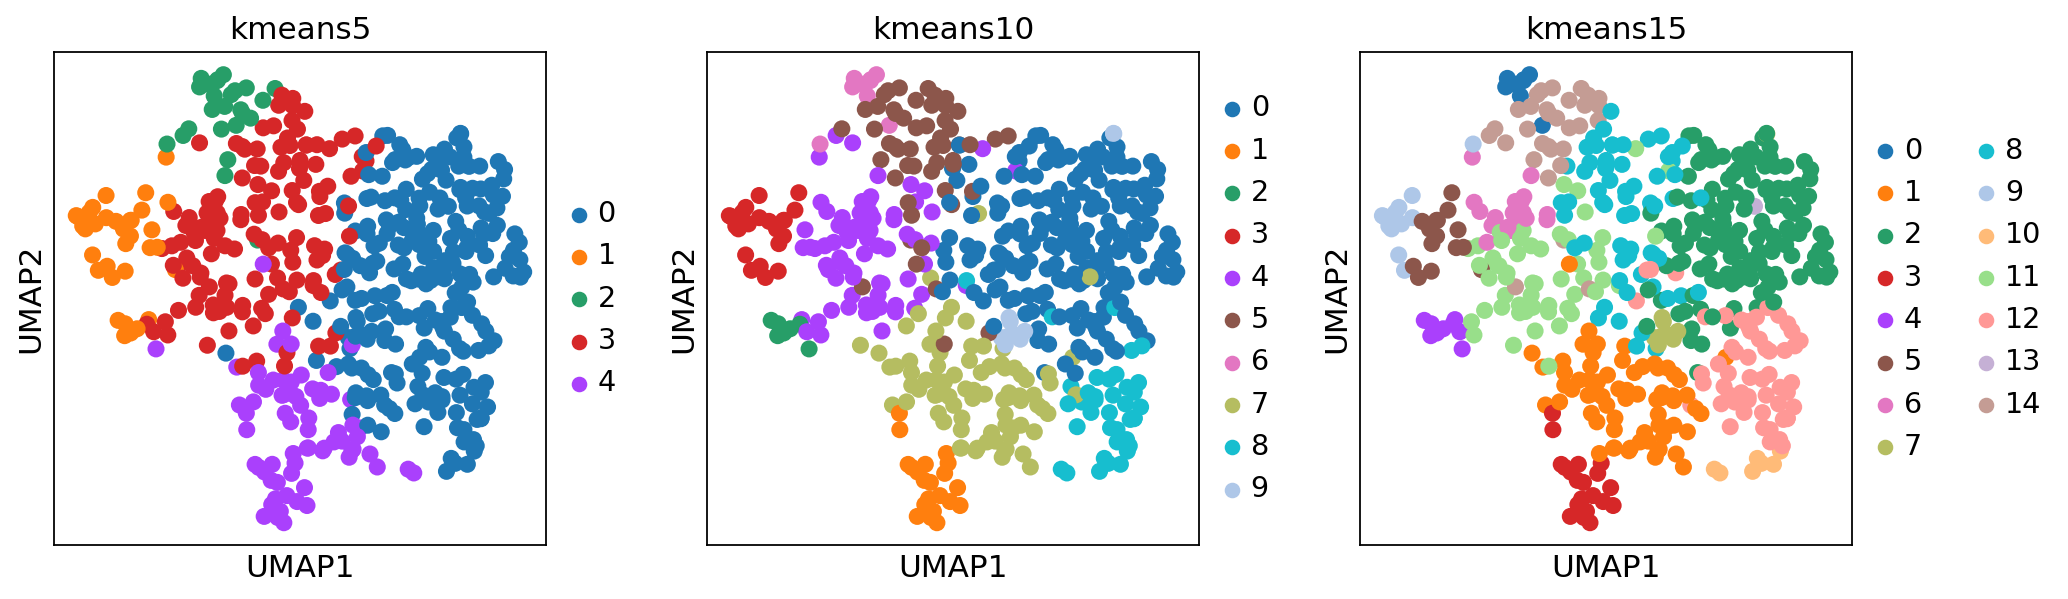

In [272]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# extract pca coordinates
X_pca = adata.obsm['X_pca'] 

# kmeans with k=5
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_pca) 
adata.obs['kmeans5'] = kmeans.labels_.astype(str)

# kmeans with k=10
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_pca) 
adata.obs['kmeans10'] = kmeans.labels_.astype(str)

# kmeans with k=15
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_pca) 
adata.obs['kmeans15'] = kmeans.labels_.astype(str)

sc.pl.umap(adata, color=['kmeans5', 'kmeans10', 'kmeans15'])

## Hierarchical clustering

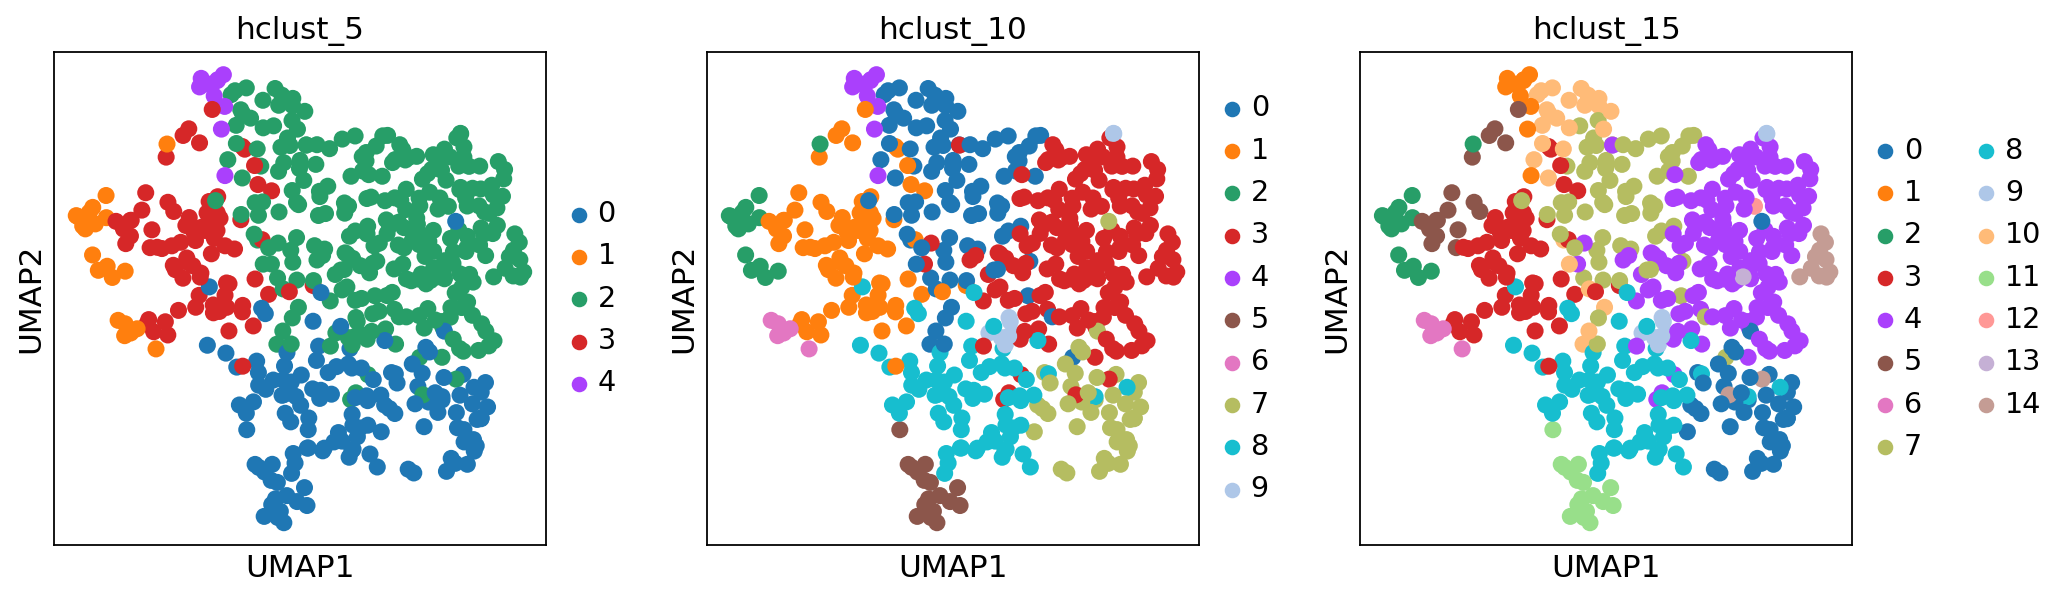

In [273]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
adata.obs['hclust_5'] = cluster.fit_predict(X_pca).astype(str)

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
adata.obs['hclust_10'] = cluster.fit_predict(X_pca).astype(str)

cluster = AgglomerativeClustering(n_clusters=15, affinity='euclidean', linkage='ward')
adata.obs['hclust_15'] = cluster.fit_predict(X_pca).astype(str)


sc.pl.umap(adata, color=['hclust_5', 'hclust_10', 'hclust_15'])

## Clinical Patient

In [274]:
df_patient = pd.read_table('data_clinical_patient.txt', sep='\t')
print(df_patient.iloc[0])

#Identifier to uniquely specify a patient.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       #STRING
Subtype                                                                                                                                                                                                                                                                                                                                                                                        

In [275]:
df_patient = df_patient.drop([0,1,2,3], axis = 0)
reset_patient = df_patient.reset_index(drop=True)

In [276]:
reset_patient

,#Identifier to uniquely specify a patient.,Subtype,Text field to hold cancer type acronym used by TCGA PanCanAtlas.,Legacy DMP patient identifier (DMPnnnn),Age at which a condition or disease was first diagnosed.,Sex,"The extent of a cancer, especially whether the disease has spread from the original site to other parts of the body based on AJCC staging criteria.","The version or edition of the American Joint Committee on Cancer Cancer Staging Handbooks, a publication by the group formed for the purpose of developing a system of clinical staging for cancer that is acceptable to the American medical profession and is compatible with other accepted classifications.","Time interval from the date of last followup to the date of initial pathologic diagnosis, represented as a calculated number of days..","Time interval from a person's date of birth to the date of initial pathologic diagnosis, represented as a calculated number of days.",...,Weight measured in kilograms.,Patient Part of PanCan Pathway Analysis,Overall patient survival status.,Overall survival in months since initial diagonosis.,The time period usually begins at the time of diagnosis or at the start of treatment and ends at the time of death.,The time period (months) usually begins at the time of diagnosis or at the start of treatment and ends at the time of death.,Disease free status since initial treatment.,Disease free (months) since initial treatment.,Progression Free Status,Progress Free Survival (Months)
0,TCGA-05-4249,LUAD,LUAD,4addf05f-3668-4b3f-a17f-c0227329ca52,67,Male,STAGE IB,6TH,1523,-24532,...,NaN,Yes,0:LIVING,50.07068416,0:ALIVE OR DEAD TUMOR FREE,50.07068416,NaN,NaN,0:CENSORED,50.07068416
1,TCGA-05-4250,LUAD,LUAD,f98ecd8a-b878-4f53-b911-20cd8e17281c,79,Female,STAGE IIIA,6TH,NaN,-29068,...,NaN,Yes,1:DECEASED,3.978038597,NaN,3.978038597,NaN,NaN,0:CENSORED,3.978038597
2,TCGA-05-4382,LUAD,LUAD,3434b91a-c05f-460f-a078-7b1bb6e7085d,68,Male,STAGE IB,6TH,607,-24868,...,NaN,Yes,0:LIVING,19.95594569,0:ALIVE OR DEAD TUMOR FREE,19.95594569,1:Recurred/Progressed,10.98070158,1:PROGRESSION,10.98070158
3,TCGA-05-4384,LUAD,LUAD,9a50e7e4-831d-489f-87d2-979e987561cc,66,Male,STAGE IIIA,6TH,426,-24411,...,NaN,Yes,0:LIVING,14.00532597,0:ALIVE OR DEAD TUMOR FREE,14.00532597,NaN,NaN,1:PROGRESSION,6.016372423
4,TCGA-05-4389,LUAD,LUAD,a3de401d-91fe-49a2-bb07-81c1a06506e6,70,Male,STAGE IA,5TH,1369,-25660,...,NaN,Yes,0:LIVING,45.00772594,0:ALIVE OR DEAD TUMOR FREE,45.00772594,NaN,NaN,0:CENSORED,45.00772594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,TCGA-17-Z045,NaN,LUAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561,TCGA-17-Z031,NaN,LUAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
562,TCGA-17-Z049,NaN,LUAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563,TCGA-17-Z060,NaN,LUAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [277]:
reset_patient.describe()

,#Identifier to uniquely specify a patient.,Subtype,Text field to hold cancer type acronym used by TCGA PanCanAtlas.,Legacy DMP patient identifier (DMPnnnn),Age at which a condition or disease was first diagnosed.,Sex,"The extent of a cancer, especially whether the disease has spread from the original site to other parts of the body based on AJCC staging criteria.","The version or edition of the American Joint Committee on Cancer Cancer Staging Handbooks, a publication by the group formed for the purpose of developing a system of clinical staging for cancer that is acceptable to the American medical profession and is compatible with other accepted classifications.","Time interval from the date of last followup to the date of initial pathologic diagnosis, represented as a calculated number of days..","Time interval from a person's date of birth to the date of initial pathologic diagnosis, represented as a calculated number of days.",...,Weight measured in kilograms.,Patient Part of PanCan Pathway Analysis,Overall patient survival status.,Overall survival in months since initial diagonosis.,The time period usually begins at the time of diagnosis or at the start of treatment and ends at the time of death.,The time period (months) usually begins at the time of diagnosis or at the start of treatment and ends at the time of death.,Disease free status since initial treatment.,Disease free (months) since initial treatment.,Progression Free Status,Progress Free Survival (Months)
count,565,501,565,513,494,513,511,492,391,482,...,0,565,513,504,477,504,304,301,513,504
unique,565,1,1,513,52,2,9,5,331,473,...,0,2,2,432,2,432,2,270,2,422
top,TCGA-05-4249,LUAD,LUAD,4addf05f-3668-4b3f-a17f-c0227329ca52,70,Female,STAGE IB,7TH,791,-30689,...,NaN,Yes,0:LIVING,26.00519446,0:ALIVE OR DEAD TUMOR FREE,26.00519446,0:DiseaseFree,16.9313213,0:CENSORED,16.9313213
freq,1,501,565,1,25,275,139,269,4,2,...,NaN,501,327,4,363,4,215,3,305,4


In [278]:
patient_cluster = pd.merge(left=reset_patient, right=leiden_cluster, left_on='#Identifier to uniquely specify a patient.', right_on="index")
patient_cluster

,#Identifier to uniquely specify a patient.,Subtype,Text field to hold cancer type acronym used by TCGA PanCanAtlas.,Legacy DMP patient identifier (DMPnnnn),Age at which a condition or disease was first diagnosed.,Sex,"The extent of a cancer, especially whether the disease has spread from the original site to other parts of the body based on AJCC staging criteria.","The version or edition of the American Joint Committee on Cancer Cancer Staging Handbooks, a publication by the group formed for the purpose of developing a system of clinical staging for cancer that is acceptable to the American medical profession and is compatible with other accepted classifications.","Time interval from the date of last followup to the date of initial pathologic diagnosis, represented as a calculated number of days..","Time interval from a person's date of birth to the date of initial pathologic diagnosis, represented as a calculated number of days.",...,Overall patient survival status.,Overall survival in months since initial diagonosis.,The time period usually begins at the time of diagnosis or at the start of treatment and ends at the time of death.,The time period (months) usually begins at the time of diagnosis or at the start of treatment and ends at the time of death.,Disease free status since initial treatment.,Disease free (months) since initial treatment.,Progression Free Status,Progress Free Survival (Months),index,leiden
0,TCGA-05-4249,LUAD,LUAD,4addf05f-3668-4b3f-a17f-c0227329ca52,67,Male,STAGE IB,6TH,1523,-24532,...,0:LIVING,50.07068416,0:ALIVE OR DEAD TUMOR FREE,50.07068416,NaN,NaN,0:CENSORED,50.07068416,TCGA-05-4249,0
1,TCGA-05-4250,LUAD,LUAD,f98ecd8a-b878-4f53-b911-20cd8e17281c,79,Female,STAGE IIIA,6TH,NaN,-29068,...,1:DECEASED,3.978038597,NaN,3.978038597,NaN,NaN,0:CENSORED,3.978038597,TCGA-05-4250,0
2,TCGA-05-4382,LUAD,LUAD,3434b91a-c05f-460f-a078-7b1bb6e7085d,68,Male,STAGE IB,6TH,607,-24868,...,0:LIVING,19.95594569,0:ALIVE OR DEAD TUMOR FREE,19.95594569,1:Recurred/Progressed,10.98070158,1:PROGRESSION,10.98070158,TCGA-05-4382,1
3,TCGA-05-4384,LUAD,LUAD,9a50e7e4-831d-489f-87d2-979e987561cc,66,Male,STAGE IIIA,6TH,426,-24411,...,0:LIVING,14.00532597,0:ALIVE OR DEAD TUMOR FREE,14.00532597,NaN,NaN,1:PROGRESSION,6.016372423,TCGA-05-4384,2
4,TCGA-05-4389,LUAD,LUAD,a3de401d-91fe-49a2-bb07-81c1a06506e6,70,Male,STAGE IA,5TH,1369,-25660,...,0:LIVING,45.00772594,0:ALIVE OR DEAD TUMOR FREE,45.00772594,NaN,NaN,0:CENSORED,45.00772594,TCGA-05-4389,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,TCGA-NJ-A55O,LUAD,LUAD,8AB8C4BA-311E-41D0-85EA-A0245ACA1BDD,56,Female,STAGE IIA,7TH,13,-20628,...,0:LIVING,0.427392577,0:ALIVE OR DEAD TUMOR FREE,0.427392577,NaN,NaN,0:CENSORED,0.427392577,TCGA-NJ-A55O,3
505,TCGA-NJ-A55R,LUAD,LUAD,7C7D777B-BF00-4C24-97FC-922580D5605F,67,Male,STAGE IA,7TH,603,-24738,...,0:LIVING,19.82444028,0:ALIVE OR DEAD TUMOR FREE,19.82444028,NaN,NaN,0:CENSORED,19.82444028,TCGA-NJ-A55R,2
506,TCGA-NJ-A7XG,LUAD,LUAD,01E9888D-B5B9-48F1-8BA6-8A89AF108A04,49,Male,STAGE IIIA,7TH,617,-18127,...,0:LIVING,20.28470921,0:ALIVE OR DEAD TUMOR FREE,20.28470921,NaN,NaN,0:CENSORED,20.28470921,TCGA-NJ-A7XG,3
507,TCGA-O1-A52J,LUAD,LUAD,42432463-8E92-4F25-B72A-F03953527AA5,74,Female,STAGE IA,6TH,NaN,-27223,...,1:DECEASED,59.11168097,1:DEAD WITH TUMOR,59.11168097,NaN,NaN,1:PROGRESSION,29.52296413,TCGA-O1-A52J,5


In [279]:
patient_cluster.columns

Index(['#Identifier to uniquely specify a patient.', 'Subtype',
       'Text field to hold cancer type acronym used by TCGA PanCanAtlas.',
       'Legacy DMP patient identifier (DMPnnnn)',
       'Age at which a condition or disease was first diagnosed.', 'Sex',
       'The extent of a cancer, especially whether the disease has spread from the original site to other parts of the body based on AJCC staging criteria.',
       'The version or edition of the American Joint Committee on Cancer Cancer Staging Handbooks, a publication by the group formed for the purpose of developing a system of clinical staging for cancer that is acceptable to the American medical profession and is compatible with other accepted classifications.',
       'Time interval from the date of last followup to the date of initial pathologic diagnosis, represented as a calculated number of days..',
       'Time interval from a person's date of birth to the date of initial pathologic diagnosis, represented as a calcul

In [280]:
droper = ['Subtype','Text field to hold cancer type acronym used by TCGA PanCanAtlas.',
       'Legacy DMP patient identifier (DMPnnnn)',
       'The extent of a cancer, especially whether the disease has spread from the original site to other parts of the body based on AJCC staging criteria.',
       'The version or edition of the American Joint Committee on Cancer Cancer Staging Handbooks, a publication by the group formed for the purpose of developing a system of clinical staging for cancer that is acceptable to the American medical profession and is compatible with other accepted classifications.',
       'Time interval from the date of last followup to the date of initial pathologic diagnosis, represented as a calculated number of days..',
       "Time interval from a person's date of birth to the date of initial pathologic diagnosis, represented as a calculated number of days.",
       'Time interval from the last day on which a person is known to be alive to the date of initial pathologic diagnosis, represented as a calculated number of days.',
       'Form completion date',
       "Text term to describe the patient's history of neoadjuvant treatment and the kind of treatment given prior to resection of the tumor.",
       '10th revision of the International Statistical Classification of Diseases and Related Health Problems.',
       'The third edition of the International Classification of Diseases for Oncology, published in 2000, used principally in tumor and cancer registries for coding the site (topography) and the histology (morphology) of neoplasms._The study of the structure of the cells and their arrangement to constitute tissues and, finally, the association among these to form organs.  In pathology, the microscopic process of identifying normal and abnormal morphologic characteristics in tissues, by employing various cytochemical and immunocytochemical stains._A system of numbered categories for representation of data.',
       'The third edition of the International Classification of Diseases for Oncology, published in 2000, used principally in tumor and cancer registries for coding the site (topography) and the histology (morphology) of neoplasms._The description of an anatomical region or of a body part._Named locations of, or within, the body._A system of numbered categories for representation of data.',
       'Informed consent verified',
       'Yes/No/Unknown indicator to identify whether a patient has had a new tumor event after initial treatment.',
       'Code to represent the defined absence or presence of distant spread or metastases (M) to locations via vascular channels or lymphatics beyond the regional lymph nodes, using criteria established by the American Joint Committee on Cancer (AJCC).',
       "The codes that represent the stage of cancer based on the nodes present (N stage) according to criteria based on multiple editions of the AJCC's Cancer Staging Manual.",
       'Code of pathological T (primary tumor) to define the size or contiguous extension of the primary tumor (T), using staging criteria from the American Joint Committee on Cancer (AJCC).',
       'Primary lymph node presentation assessment.', 'Prior diagnosis.',
       'The time period usually begins at the time of diagnosis or at the start of treatment and ends at the time of death.',
       'The time period (months) usually begins at the time of diagnosis or at the start of treatment and ends at the time of death.',
       'Disease free status since initial treatment.','The text for reporting information about ethnicity.',
       'Disease free (months) since initial treatment.','index','The text for reporting information about race.',
         'Weight measured in kilograms.']

In [281]:
clean_patient_cluster = patient_cluster.drop(droper, axis=1).reset_index(drop=True)
clean_patient_cluster.head()

,#Identifier to uniquely specify a patient.,Age at which a condition or disease was first diagnosed.,Sex,Person neoplasm cancer status.,Radiation Therapy.,Patient Part of PanCan Pathway Analysis,Overall patient survival status.,Overall survival in months since initial diagonosis.,Progression Free Status,Progress Free Survival (Months),leiden
0,TCGA-05-4249,67,Male,Tumor Free,No,Yes,0:LIVING,50.07068416,0:CENSORED,50.07068416,0
1,TCGA-05-4250,79,Female,NaN,NaN,Yes,1:DECEASED,3.978038597,0:CENSORED,3.978038597,0
2,TCGA-05-4382,68,Male,Tumor Free,Yes,Yes,0:LIVING,19.95594569,1:PROGRESSION,10.98070158,1
3,TCGA-05-4384,66,Male,NaN,Yes,Yes,0:LIVING,14.00532597,1:PROGRESSION,6.016372423,2
4,TCGA-05-4389,70,Male,Tumor Free,No,Yes,0:LIVING,45.00772594,0:CENSORED,45.00772594,0


In [282]:
binary_columns = ['Overall patient survival status.', 'Progression Free Status']
for col in binary_columns:
    clean_patient_cluster[col] = pd.to_numeric(clean_patient_cluster[col].str[0])

In [283]:
clean_patient_cluster['Radiation Therapy.'].unique()

array(['No', nan, 'Yes'], dtype=object)

In [284]:
interpret = True

In [285]:
if interpret == True:   
    clean_patient_cluster['Person neoplasm cancer status.'] = clean_patient_cluster['Person neoplasm cancer status.'].map({'With Tumor': 1, 'Tumor Free': 0})
    clean_patient_cluster['Radiation Therapy.'] = clean_patient_cluster['Radiation Therapy.'].map({'Yes': 1, 'No': 0})
    clean_patient_cluster['Patient Part of PanCan Pathway Analysis'] = clean_patient_cluster['Patient Part of PanCan Pathway Analysis'].map({'Yes': 1, 'No': 0})
    clean_patient_cluster['Sex'] = clean_patient_cluster['Sex'].map({'Male': 1, 'Female': 0})

In [286]:
clean_patient_cluster.head()

,#Identifier to uniquely specify a patient.,Age at which a condition or disease was first diagnosed.,Sex,Person neoplasm cancer status.,Radiation Therapy.,Patient Part of PanCan Pathway Analysis,Overall patient survival status.,Overall survival in months since initial diagonosis.,Progression Free Status,Progress Free Survival (Months),leiden
0,TCGA-05-4249,67,1,0.0,0.0,1,0,50.07068416,0,50.07068416,0
1,TCGA-05-4250,79,0,NaN,NaN,1,1,3.978038597,0,3.978038597,0
2,TCGA-05-4382,68,1,0.0,1.0,1,0,19.95594569,1,10.98070158,1
3,TCGA-05-4384,66,1,NaN,1.0,1,0,14.00532597,1,6.016372423,2
4,TCGA-05-4389,70,1,0.0,0.0,1,0,45.00772594,0,45.00772594,0


In [287]:
clean_patient_cluster.columns

Index(['#Identifier to uniquely specify a patient.',
       'Age at which a condition or disease was first diagnosed.', 'Sex',
       'Person neoplasm cancer status.', 'Radiation Therapy.',
       'Patient Part of PanCan Pathway Analysis',
       'Overall patient survival status.',
       'Overall survival in months since initial diagonosis.',
       'Progression Free Status', 'Progress Free Survival (Months)', 'leiden'],
      dtype='object')

In [288]:
clean_patient_cluster= clean_patient_cluster.loc[:, ~clean_patient_cluster.columns.duplicated()].dropna(axis=0)

In [289]:
clean_patient_cluster

,#Identifier to uniquely specify a patient.,Age at which a condition or disease was first diagnosed.,Sex,Person neoplasm cancer status.,Radiation Therapy.,Patient Part of PanCan Pathway Analysis,Overall patient survival status.,Overall survival in months since initial diagonosis.,Progression Free Status,Progress Free Survival (Months),leiden
0,TCGA-05-4249,67,1,0.0,0.0,1,0,50.07068416,0,50.07068416,0
2,TCGA-05-4382,68,1,0.0,1.0,1,0,19.95594569,1,10.98070158,1
4,TCGA-05-4389,70,1,0.0,0.0,1,0,45.00772594,0,45.00772594,0
5,TCGA-05-4390,58,0,0.0,0.0,1,0,37.0187724,1,12.98615906,2
9,TCGA-05-4398,47,0,0.0,0.0,1,0,47.04605977,0,47.04605977,0
...,...,...,...,...,...,...,...,...,...,...,...
504,TCGA-NJ-A55O,56,0,0.0,0.0,1,0,0.427392577,0,0.427392577,3
505,TCGA-NJ-A55R,67,1,0.0,0.0,1,0,19.82444028,0,19.82444028,2
506,TCGA-NJ-A7XG,49,1,1.0,0.0,1,0,20.28470921,0,20.28470921,3
507,TCGA-O1-A52J,74,0,1.0,0.0,1,1,59.11168097,1,29.52296413,5


In [290]:
df_genes = data_clean.add_prefix('gene_')
df_genes['ID'] = df_genes.index.str[:-3]
df_genes = df_genes.reset_index(drop=True)

In [291]:
df_merge = pd.merge(clean_patient_cluster, df_genes, left_on='#Identifier to uniquely specify a patient.', right_on='ID').drop('ID', axis=1)
df_merge.head()

,#Identifier to uniquely specify a patient.,Age at which a condition or disease was first diagnosed.,Sex,Person neoplasm cancer status.,Radiation Therapy.,Patient Part of PanCan Pathway Analysis,Overall patient survival status.,Overall survival in months since initial diagonosis.,Progression Free Status,Progress Free Survival (Months),...,gene_55055,gene_11130,gene_7789,gene_158586,gene_79364,gene_440590,gene_79699,gene_7791,gene_23140,gene_26009
0,TCGA-05-4249,67,1,0.0,0.0,1,0,50.07068416,0,50.07068416,...,198.589,287.507,62.1376,493.560,1179.330,20.2833,787.506,2351.25,1138.120,690.275
1,TCGA-05-4382,68,1,0.0,1.0,1,0,19.95594569,1,10.98070158,...,429.630,753.090,40.4424,346.752,946.687,64.8514,908.159,6770.15,1169.240,663.830
2,TCGA-05-4389,70,1,0.0,0.0,1,0,45.00772594,0,45.00772594,...,413.262,889.262,79.5302,625.503,1011.410,71.8121,534.899,2565.44,679.195,753.020
3,TCGA-05-4390,58,0,0.0,0.0,1,0,37.0187724,1,12.98615906,...,326.361,1444.680,48.5390,713.396,784.927,7.6641,618.234,5256.27,780.457,491.138
4,TCGA-05-4398,47,0,0.0,0.0,1,0,47.04605977,0,47.04605977,...,374.813,640.278,18.2688,230.535,973.032,119.1820,700.304,6066.77,593.736,640.061


In [292]:
df_merge.columns

Index(['#Identifier to uniquely specify a patient.',
       'Age at which a condition or disease was first diagnosed.', 'Sex',
       'Person neoplasm cancer status.', 'Radiation Therapy.',
       'Patient Part of PanCan Pathway Analysis',
       'Overall patient survival status.',
       'Overall survival in months since initial diagonosis.',
       'Progression Free Status', 'Progress Free Survival (Months)',
       ...
       'gene_55055', 'gene_11130', 'gene_7789', 'gene_158586', 'gene_79364',
       'gene_440590', 'gene_79699', 'gene_7791', 'gene_23140', 'gene_26009'],
      dtype='object', length=20542)

In [293]:
df_merge= df_merge.loc[:, ~df_merge.columns.duplicated()].drop('#Identifier to uniquely specify a patient.', axis=1).dropna(axis=0)
df_merge

,Age at which a condition or disease was first diagnosed.,Sex,Person neoplasm cancer status.,Radiation Therapy.,Patient Part of PanCan Pathway Analysis,Overall patient survival status.,Overall survival in months since initial diagonosis.,Progression Free Status,Progress Free Survival (Months),leiden,...,gene_55055,gene_11130,gene_7789,gene_158586,gene_79364,gene_440590,gene_79699,gene_7791,gene_23140,gene_26009
0,67,1,0.0,0.0,1,0,50.07068416,0,50.07068416,0,...,198.589,287.507,62.1376,493.560,1179.330,20.2833,787.506,2351.25,1138.120,690.275
1,68,1,0.0,1.0,1,0,19.95594569,1,10.98070158,1,...,429.630,753.090,40.4424,346.752,946.687,64.8514,908.159,6770.15,1169.240,663.830
2,70,1,0.0,0.0,1,0,45.00772594,0,45.00772594,0,...,413.262,889.262,79.5302,625.503,1011.410,71.8121,534.899,2565.44,679.195,753.020
3,58,0,0.0,0.0,1,0,37.0187724,1,12.98615906,2,...,326.361,1444.680,48.5390,713.396,784.927,7.6641,618.234,5256.27,780.457,491.138
4,47,0,0.0,0.0,1,0,47.04605977,0,47.04605977,0,...,374.813,640.278,18.2688,230.535,973.032,119.1820,700.304,6066.77,593.736,640.061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,56,0,0.0,0.0,1,0,0.427392577,0,0.427392577,3,...,212.369,368.728,40.8401,329.055,1107.350,17.5029,726.371,4185.53,1333.720,585.181
365,67,1,0.0,0.0,1,0,19.82444028,0,19.82444028,2,...,156.134,447.889,50.6998,374.362,1485.430,52.6221,757.854,3077.79,1989.310,611.762
366,49,1,1.0,0.0,1,0,20.28470921,0,20.28470921,3,...,122.592,170.807,16.9433,168.975,1224.960,10.0744,531.654,1995.19,1424.160,426.789
367,74,0,1.0,0.0,1,1,59.11168097,1,29.52296413,5,...,133.885,368.421,136.3640,562.679,1296.650,0.4785,782.297,4483.25,1520.570,477.990


## Preprocessing

In [327]:
var = ['Overall survival in months since initial diagonosis.']

y = df_merge[var]
y = y.apply(pd.to_numeric)


y = StandardScaler().fit_transform(y)


X = df_merge.drop(var, axis=1).reset_index(drop=True)
X = X.drop(['Progress Free Survival (Months)',
            'Overall patient survival status.', 'Progression Free Status'],
            axis=1).reset_index(drop=True) # should not be predictors


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

In [328]:
if interpret == True:
    categorical_features = ['Sex']
else:
    categorical_features = ['Sex','Person neoplasm cancer status.',
                            'Radiation Therapy.','Patient Part of PanCan Pathway Analysis', 
                            ]


numeric_features = X_train.drop(categorical_features, axis=1)
numeric_features = numeric_features.columns.tolist()


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [329]:
if interpret == True:
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ]
        )
    preprocess=preprocessor.fit(X_train.drop(categorical_features, axis=1).reset_index(drop=True)) 
else:

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
            ]
            )

    #Fit your preprocessor object
    preprocess=preprocessor.fit(X_train) 

In [330]:
X_train = preprocess.transform(X_train)
X_test = preprocess.transform(X_test)

In [331]:
X_train.shape

(276, 20511)

## XGBoost

In [332]:
xgbr = xgb.XGBRegressor(n_estimators=10)

xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [333]:
print('train: ', xgbr.score(X_train, y_train))
print('test: ', xgbr.score(X_test, y_test))

train:  0.9726976955722717
test:  -0.25316857554693795


## LASSO

In [334]:
lasso = LassoCV(cv=2, random_state=0).fit(X_train, y_train)

In [335]:
print('train: ', lasso.score(X_train, y_train), '\ntest: ', lasso.score(X_test, y_test))

train:  0.0 
test:  -0.004769983641210063


## Random Forest

In [336]:
from sklearn.model_selection import train_test_split

X = df_merge.drop('Overall patient survival status.', axis=1)
y = df_merge['Overall patient survival status.']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [337]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(score)

0.6081081081081081


In [338]:
clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [339]:
from sklearn import metrics  
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.5675675675675675


## COX Elastic Net

In [340]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [341]:
df_y_cox = pd.concat([df_merge['Overall patient survival status.'].astype(bool), df_merge['Overall survival in months since initial diagonosis.'].apply(pd.to_numeric)], axis=1).to_records(index=False)


In [342]:
y = df_y_cox

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)
X_train = preprocess.transform(X_train)
X_test = preprocess.transform(X_test)

In [343]:
cox_elastic_net = CoxnetSurvivalAnalysis()
params = {'l1_ratio':np.arange(0.4,1.,0.05), "alpha_min_ratio":np.arange(0.1,0.7,0.05)}
cox_net_cv = GridSearchCV(cox_elastic_net,
                        param_grid=params,
                        n_jobs=-1,
                        cv=10
                        )

cox_net = CoxnetSurvivalAnalysis(l1_ratio= 0.9, alpha_min_ratio= 0.25)

In [344]:
cox_net.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.25, l1_ratio=0.9)

In [345]:
print("Train score: {:.3f}".format(cox_net.score(X_train, y_train)), "\nTest score: {:.3f}".format(cox_net.score(X_test, y_test)))

Train score: 0.886 
Test score: 0.699


## RF Surv

In [346]:
rsf = RandomSurvivalForest(n_estimators=10,
                           min_samples_split=10,
                           min_samples_leaf=10,
                           n_jobs=-1,
                           random_state=42)

In [347]:
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=10, min_samples_split=10, n_estimators=10,
                     n_jobs=-1, random_state=42)

In [348]:
print("Train score: {:.3f}".format(rsf.score(X_train, y_train)), "\nTest score: {:.3f}".format(rsf.score(X_test, y_test)))

Train score: 0.896 
Test score: 0.612


## Gradient Boosting Survival

In [349]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=10, learning_rate=1, max_depth=1, random_state=42
)
est_cph_tree.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(learning_rate=1, max_depth=1, n_estimators=10,
                                 random_state=42)

In [350]:
print("Train score: {:.3f}".format(est_cph_tree.score(X_train, y_train)), "\nTest score: {:.3f}".format(est_cph_tree.score(X_test, y_test)))

Train score: 0.826 
Test score: 0.730


## Feature Importance

In [351]:
cv=False

In [352]:
if cv==True:
    cox_net_cv.fit(X_train, y_train)

In [353]:
if cv==True:
    #extract best score and parameter by calling objects "best_score_" and "best_params_"
    print("best mean cross-validation score: {:.3f}".format(cox_net_cv.best_score_))
    print("best parameters: {}".format(cox_net_cv.best_params_))
    print("Train score: {:.3f}".format(cox_net_cv.score(X_train, y_train)), "\nTest score: {:.3f}".format(cox_net_cv.score(X_test, y_test)))


In [354]:
estimated_alphas = cox_net.alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.25)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=-1)

In [355]:
gcv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=0.5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('coxnetsurvivalanalysis',
                                        CoxnetSurvivalAnalysis(alpha_min_ratio=0.25,
                                                               l1_ratio=0.9))]),
             n_jobs=-1,
             param_grid={'coxnetsurvivalanalysis__alphas': [[0.3006267729545708],
                                                            [0.2964464411114225],
                                                            [0.2923242384034377],
                                                            [0.2...
                                                            [0.24710859887997136],
                                                            [0.243672457998501],
                                                            [0.24028409798831893],
           

In [356]:
cv_results = pd.DataFrame(gcv.cv_results_)

Number of non-zero coefficients: 9


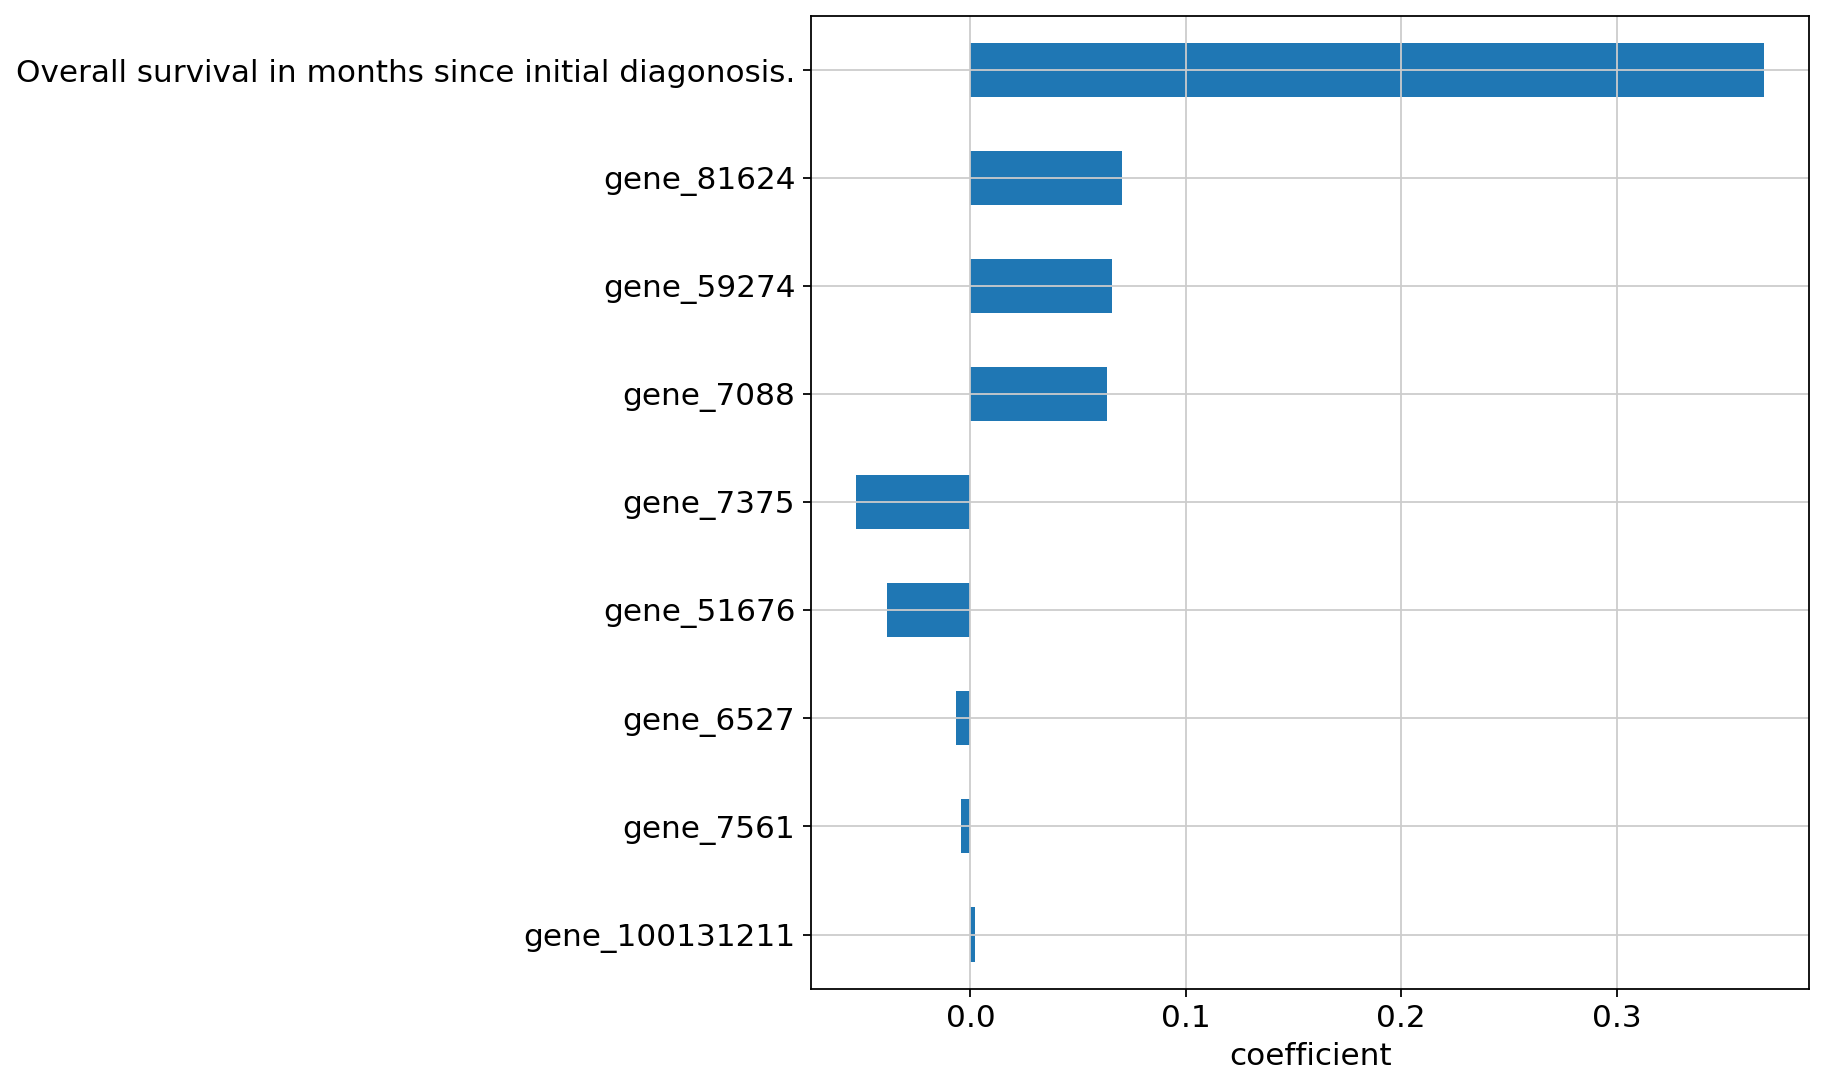

In [357]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X.drop(['Sex','Person neoplasm cancer status.',
                            'Radiation Therapy.','Patient Part of PanCan Pathway Analysis'], axis=1).reset_index(drop=True).columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(8, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False,)
ax.set_xlabel("coefficient")
ax.grid(True)

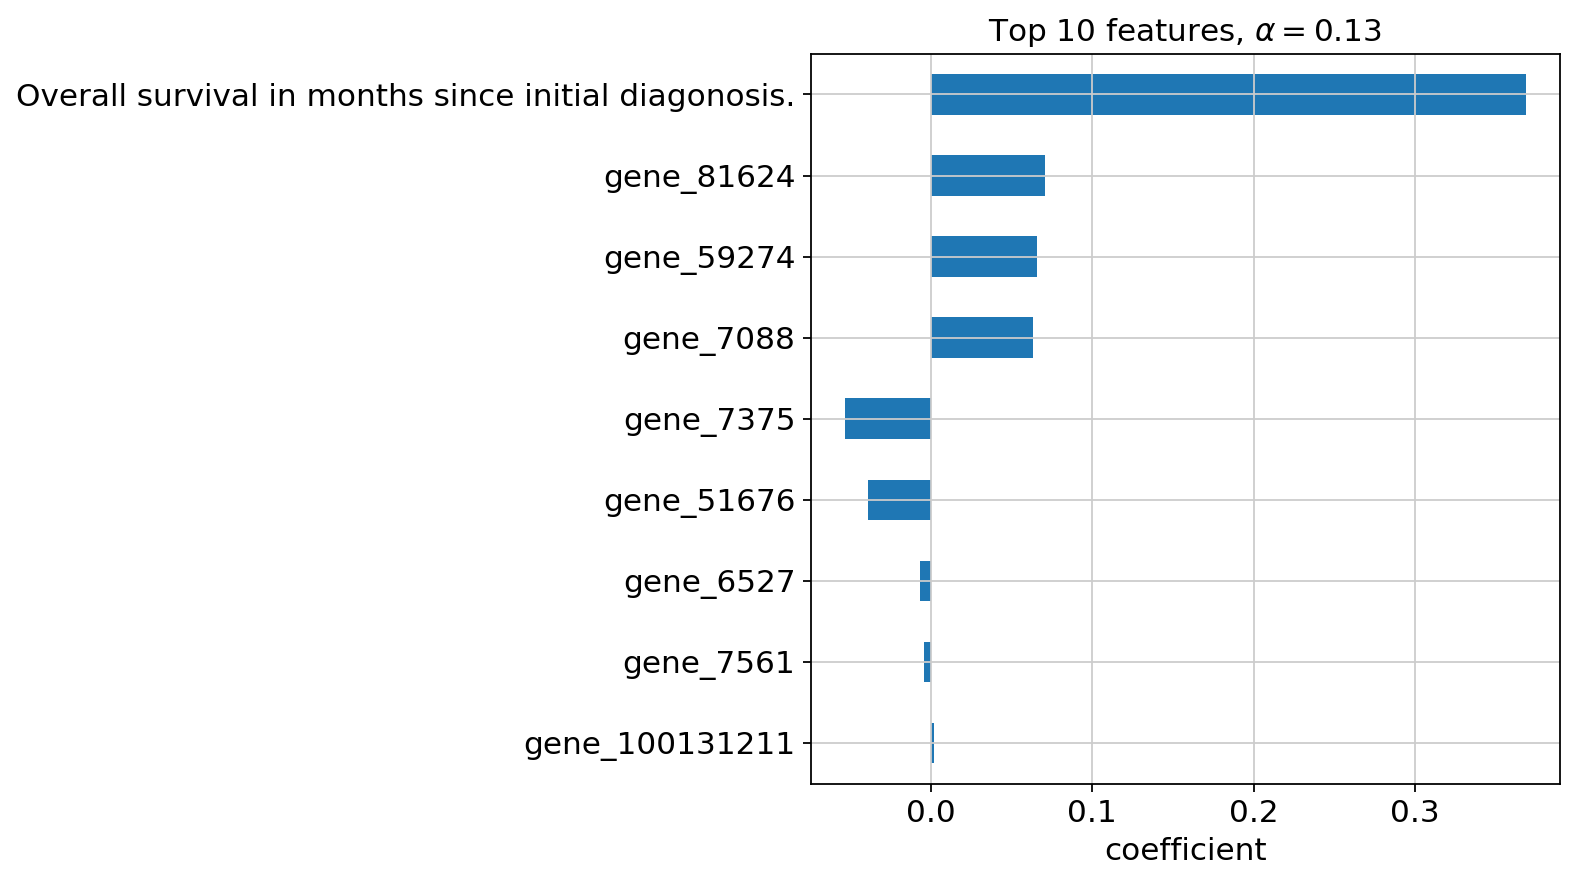

In [358]:
_, ax = plt.subplots(figsize=(6, 6))
alpha = round(best_model.alphas_[0],2)
non_zero_coefs.loc[coef_order]['coefficient'].tail(10).plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.set_title(f'Top 10 features, $\\alpha={alpha} $')
ax.grid(True)